# PROGRAM FDinplane
2-d rectangle o-4 stress velocity inplane

Stefan Nielsen - February 2019

import standard python libraries:

In [1]:
# Stefan Nielsen 2018 - various lib import:
#%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
import os
import time
import numpy as np
%matplotlib notebook
import matplotlib
#import matplotlib.pyplot as plt
#matplotlib.interactive(True)
from pylab import plot, xlabel, ylabel
from pylab import *
from scipy import arange
from IPython import display
from matplotlib import animation, rc
import matplotlib.ticker as ticker
#####
from fatiando import seismic_wiggle

initialise parameters and arrays, importing from local files:

In [2]:
from FDfpar import *       #
from FDarrays import *     #

mu[:,:]=.3e9
lam[:,:]=.3e9
rho[:,:]=2000.
rn=9./8.;rnn=-1/24.;
#
# viscoelastic attenuation (relaxation time) at the sides and bottom boundaries:
diss[:,:]=.1;lbuf=3.0;dimi=.002;nbuf=15;
for i in range(nbuf): diss[:,i]=(diss[:,i]-dimi)*np.exp(-(float(nbuf-i)/lbuf)**2)+dimi
for i in range(nx-nbuf,nx): diss[:,i]=(diss[:,i]-dimi)*np.exp(-(float(i-nx+nbuf+1)/lbuf)**2)+dimi
for j in range(ny-nbuf,ny): diss[j,:]=(diss[j,:]-dimi)*np.exp(-(float(j-ny+nbuf+1)/lbuf)**2)+dimi
# source position:
nxs=20;nys=2;
# initialize variables:
def init(v1,v2,s11,s22,s12):
    v1[:,:]=0;v2[:,:]=0;s11[:,:]=0;s22[:,:]=0;s12[:,:]=0;
print("Vp=",np.amax(sqrt((lam+2*mu)/rho)) )
print("Vs=",np.amax(sqrt((mu)/rho)))

Vp= 670.820393249937
Vs= 387.2983346207417


f, axarr = plt.subplots(1,1,figsize=(6,2))
axarr.plot(diss[:,30])
axarr.set_title('diss');
f.canvas.draw()

In [3]:
# here you can modify the model by adding ihomogenieities:
for j in range(12,ny):
    mu[j,:]=5.5e9
    lam[j,:]=5.5e9
print("min. Vp=",np.amin(sqrt((lam+2*mu)/rho)) )
print("min. Vs=",np.amin(sqrt((mu)/rho)))
print("max. Vp=",np.amax(sqrt((lam+2*mu)/rho)) )
print("max. Vs=",np.amax(sqrt((mu)/rho)))

min. Vp= 670.820393249937
min. Vs= 387.2983346207417
max. Vp= 2872.281323269014
max. Vs= 1658.3123951777


In [4]:
### dt reset for stability:
dt = (1/2)*dx/np.amax(sqrt((lam+2*mu)/rho))
dt

0.00017407765595569785

## define functions:

In [5]:
def memvar(m11,mm11,m22,mm22,m12,mm12):
    # memory variables for viscoelastic attenuation
    mm11=m11[:,:]
    mm22=m22[:,:]
    mm12=m12[:,:]
    m11=s11[:,:]
    m22=s22[:,:]
    m12=s22[:,:]

## Stress update following from the time derivative of Hooke's law:
$$ \dot{\sigma}_{11} =(\lambda+2\mu)\ \dot{\epsilon}_{11}+\lambda \dot{\epsilon}_{22}  $$
$$ \dot{\sigma}_{22} =(\lambda+2\mu)\ \dot{\epsilon}_{22}+\lambda \dot{\epsilon}_{11}  $$
$$ \dot{\sigma}_{12} = 2\mu\ \dot{\epsilon}_{12}  $$

where $$\dot{\epsilon}_{11}=\partial v_1 / \partial x_1$$ ($v_1$ being the particle velocity along $x_1$.

If  $v_1[j,i]$ is velocity at position $(y,x)=[j\ dx, i\ dx]$ on the numerical grid, 
its spatial derivative in direction $x_1$, at point $(y,\ x-\frac{1}{2}dx)$ within second order approximation is:
$$
\dot{\epsilon}_{11}\approx \frac{(v_1[j,i]-v_1[j,i-1]))}{dx}
$$

The second order approximation of the derivative in time of stress (forward Euler):
$$\dot\sigma(t)\approx(\sigma(t+dt/2)-\sigma(t-dt/2))/dt $$
$$\sigma(t+t/2)=dt\ \dot{\sigma(t)}+\sigma(t-dt/2)$$
and if $\sigma$ is implicitly the current time, it can be implicitly updated (overwritten) 
using the the last stored value:
$$\sigma=\sigma+ dt\ \dot{\sigma}(t)$$
and adding a dissipative term relaxation time $D$ to attenuate the waves at the boundaries yields:
$$\sigma=\sigma + dt\ \dot{\sigma}(t) + \frac{dt}{D} (\sigma(t-2dt)-\sigma) $$

Replacing for each stress rate term $(\dot{\sigma}_{11},\dot{\sigma}_{22},\dot{\sigma}_{12}$) with Hooke's law and strain rate expression on the grid yields the following "stress update" function "stress_o2" within second order approximation:

In [6]:
def stress_o2(s11,s22,s12):
    for i in [1,nx-2]:
        for j in [1,ny-2]:
            s11[j,i]=  s11[j,i] + \
            (dt/dx) * (                   \
            (lam[j,i]+2*mu[j,i]) *(v1[j,i]-v1[j,i-1])  \
            +lam[j,i]*(v2[j+1,i]-v2[j,i]) ) \
            +(dt/diss[j,i])*(mm11[j,i] -s11[j,i])
            #
            s22[j,i]=s22[j,i] + \
            (dt/dx)*(                        \
            (lam[j,i]+2*mu[j,i])*(v2[j+1,i]-v2[j,i])     \
            + lam[j,i]*(v1[j,i]-v1[j,i-1])  ) \
            + (dt/diss[j,i])*(mm22[j,i] -s22[j,i])
    for i in [1,nx-2]:
        for j in [1,ny-2]: 
            s12[j,i]=  s12[j,i] + \
            mu[j,i]*(dt/dx)*(            \
            (v1[j,i]-v1[j-1,i])+(v2[j,i+1]-v2[j,i])     )  \
            + (dt/diss[j,i])*(mm12[j,i]-s12[j,i])

The second order is used at the model boundaries, but for increased precision away from the boundaries the second order approximation in space is used whereby:
$$
\dot{\epsilon}_{11}\approx \frac{r_n\ (v_1[j,i]-v_1[j,i-1])+r_{nn}\ (v_1[j,i+1]-v_1[j,i-2])}{dx}
$$
(where $r_n=9./8.; \ \ r_{nn}=-1/24.$) and similiarly for the other componenets of strain rate 
$(\dot{\epsilon}_{22},\dot{\epsilon}_{12})$.
Accordingly, the fourth order stress update function "stress_o4" is defined as:


In [7]:
def stress_o4(s11,s22,s12):
    for i in range(2,nx-2):
        for j in range(2,ny-2):
            s11[j,i]=  s11[j,i] + \
            (dt/dx) * (                   \
            (lam[j,i]+2*mu[j,i]) *                              \
            (rn*(v1[j,i]-v1[j,i-1])+rnn*(v1[j,i+1]-v1[j,i-2]))  \
            +lam[j,i] *                                         \
            (rn*(v2[j+1,i]-v2[j,i])+rnn*(v2[j+2,i]-v2[j-1,i])) ) \
            +(dt/diss[j,i])*(mm11[j,i] -s11[j,i])

            #
            s22[j,i]=s22[j,i]+ \
            (dt/dx)*(                        \
            (lam[j,i]+2*mu[j,i]) *                              \
            (rn*(v2[j+1,i]-v2[j,i])+rnn*(v2[j+2,i]-v2[j-1,i]))  \
            +lam[j,i] *                                         \
            (rn*(v1[j,i]-v1[j,i-1])+rnn*(v1[j,i+1]-v1[j,i-2])  ) ) \
            + (dt/diss[j,i])*(mm22[j,i] -s22[j,i])

    for i in range(2,nx-2):
        for j in range(2,ny-2): 
            s12[j,i]=  s12[j,i] + \
            mu[j,i]*(dt/dx)*(               \
            (rn*(v1[j,i]-v1[j-1,i])+rnn*(v1[j+1,i]-v1[j-2,i]))+    \
            (rn*(v2[j,i+1]-v2[j,i])+rnn*(v2[j,i+2]-v2[j,i-1]))  ) \
            + (dt/diss[j,i])*(mm12[j,i]-s12[j,i])

## Update in the particle velocity follows from the momentum change equation:

$$
	\rho\frac{\partial v_1}{\partial t}= \frac{\partial \sigma_{11}}{\partial x_1}
	+\frac{\partial \sigma_{12}}{\partial x_2} + f_1
$$
$$
	\rho\frac{\partial v_2}{\partial t}= \frac{\partial \sigma_{22}}{\partial x_2}
	+\frac{\partial \sigma_{12}}{\partial x_1} + f_2
$$
Deferring the addition of the two body forces $f_1, f_2$ for later, and using
the second order approximation of the derivative in time of velocity (forward Euler):
$$\dot{v}(t)\approx(v(t+dt/2)-v(t-dt/2))/dt $$
$$v(t+t/2)=dt\ \dot{v(t)}+v(t-dt/2)$$
and if $v$ is implicitly the current time, it can be implicitly updated (overwritten) 
using the the last stored value:
$$v=v+ dt\ \dot{v}(t)$$
Finally, replacing $\dot{v}(t)$ by the stress divergence from the momentum change eq above, 
we otain the following functions (vel_o2 and vel_o4) for the update of the velocity field:

In [8]:
def vel_o2(v1,v2):
    for i in [1,nx-2]:
        for j in [1,ny-2]:
            v1[j,i]= v1[j,i]+(dt/(dx*rho[j,i]))*(            \
             (s11[j,i+1]-s11[j,i]) + (s12[j+1,i]-s12[j,i]) )  
            #
            v2[j,i]= v2[j,i]+(dt/(dx*rho[j,i]))*(            \
             (s22[j,i]-s22[j-1,i]) + (s12[j,i]-s12[j,i-1]) )

In [9]:
def vel_o4(v1,v2):
    for i in range(2,nx-2):
        for j in range(2,ny-2):
            v1[j,i]= v1[j,i]+(dt/(dx*rho[j,i]))*(          \
             rn*(s11[j,i+1]-s11[j,i])+rnn*(s11[j,i+2]-s11[j,i-1])     \
            +rn*(s12[j+1,i]-s12[j,i])+rnn*(s12[j+2,i]-s12[j-1,i])   )   
            #
            v2[j,i]= v2[j,i]+(dt/(dx*rho[j,i]))*(            \
             rn*(s22[j,i]-s22[j-1,i])+rnn*(s22[j+1,i]-s22[j-2,i])     \
            +rn*(s12[j,i]-s12[j,i-1])+rnn*(s12[j,i+1]-s12[j,i-2]) )

In [10]:
def ssource(s11,s22):
    rf=0.
    rf=(1./tau_s)*exp(-((float(it)*dt-2.*tau_s)/tau_s)**2)
    s22[nys,nxs]=s22[nys,nxs]+rf
    s11[nys,nxs]=s11[nys,nxs]+rf

In [11]:
def plo():
    import time
    mava=np.max(v2)
    #ax1.clear()
    #ax2.clear()
    #ax1.pcolor(v2, cmap=cm.RdBu,vmin=-mava,vmax=mava);
    p = ax1.pcolor(v2, cmap=cm.RdBu,vmin=-mava,vmax=mava);
    #cb = plt.colorbar(p,cax=ax2);
    tim=it*dt
    fig.suptitle('time=%1.3f' %tim)
    fig.canvas.draw()

In [12]:
def geophones(gg):
    fs=20
    #ns=24;ds=int((nx-fs)/(ns-1))
    ds=5;
    gg.append( [v2[2,i] for i in range(fs,nx-15,ds)] )

Interating the stress and velocity in the main time loop (while it ...) we obtain the wave propagation,
which we can represent as a colored plot:

<IPython.core.display.Javascript object>


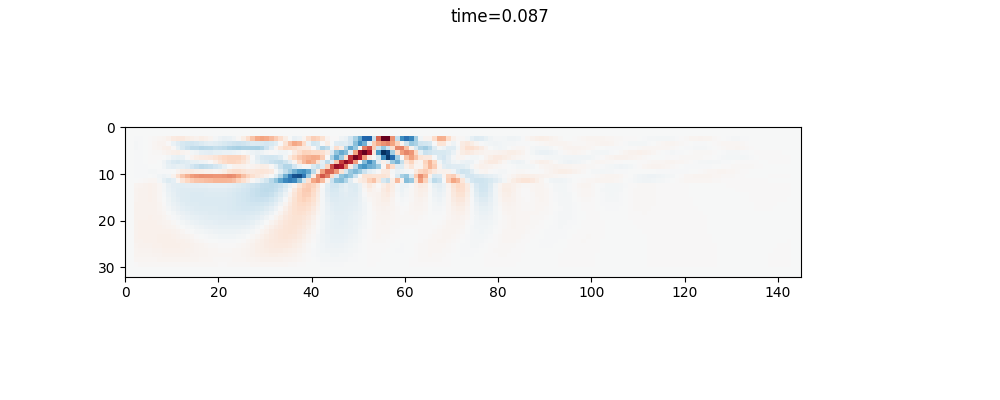

In [13]:
it=0;is1=0
startt=time.time()
#
%matplotlib notebook
import matplotlib
fig=plt.figure(figsize=(10,4))
gs=GridSpec(1,3)
ax1 = plt.subplot2grid((1,8), (0,0), colspan=7)
#ax2 = plt.subplot2grid((1,8), (0,7))
plt.ion()
fig.show()
fig.canvas.draw()
aspectratio=1.0
ratio_default=(ax1.get_xlim()[1]-ax1.get_xlim()[0])/(ax1.get_ylim()[1]-ax1.get_ylim()[0])
ax1.set_aspect(ratio_default*aspectratio)
plt.gca().invert_yaxis()
#ax2.set_aspect(4)
#
init(v1,v2,s11,s22,s12);gg=[];
try:
    while(it < ntime):
        it = it+1;
        memvar(m11,mm11,m22,mm22,m12,mm12)
        stress_o4(s11,s22,s12)
        stress_o2(s11,s22,s12)
        ssource(s11,s22)
        vel_o4(v1,v2)
        vel_o2(v1,v2)
        geophones(gg)
        is1 = is1+1
        if (is1 > nos2):        
            plo();
            is1=0  
            #print ("it="+str(it)+" — time="+str(round(it*dt,3))+" s")
except KeyboardInterrupt:
    pass
np.savetxt("gg.txt", gg, delimiter=",")

<IPython.core.display.Javascript object>


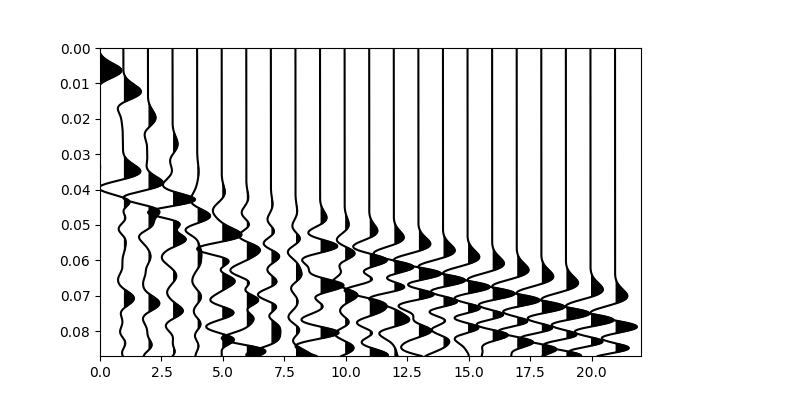

In [14]:
go=np.loadtxt("gg.txt",delimiter=",")
fig=plt.figure(figsize=(8,4))
ax1 = plt.subplot2grid((1,8), (0,0), colspan=7)
seismic_wiggle(np.array(go),dt,normalize=True)